In [7]:
import  matplotlib.pyplot as plt
import numpy as np
import os
from scipy.fft import rfft2, irfft2 
from scipy.stats import kstest
import matplotlib.cm as cm
import h5py
from python_files.maxent import MaxEnt
import python_files.densities as d

In [2]:
path_to_projections = os.getcwd()+"/skewness_kurtosis/sliced_projections/"
type = ["DMO", "HYDRO"]
sim = ["PLANCK", "LOW_S8", "FIDUCIAL"]

projections_data = h5py.File(path_to_projections+f'projected_maps_slice_5_L1000N1800_{type[0]}_{sim[0]}_8192_lc0_alpha_3.6.h5','r')
projections = projections_data['proj_maps']

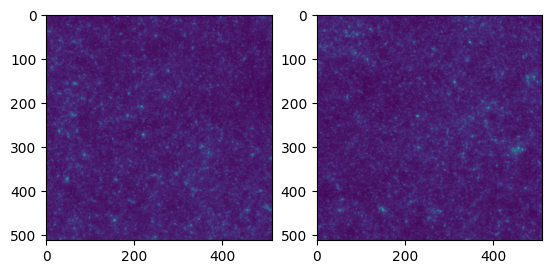

In [6]:
#HYDRO
rojections_data = h5py.File(path_to_projections+f'projected_maps_slice_5_L1000N1800_{type[1]}_{sim[0]}_8192_lc0_alpha_3.6.h5','r')
projections = projections_data['proj_maps']

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(projections[0])
ax2.imshow(projections[1])
plt.show()

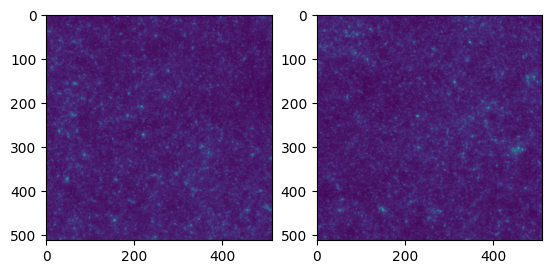

In [ ]:
# DMO

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(projections[0])
ax2.imshow(projections[1])
plt.show()

Max: 0.34 || Min: -0.04
Avg: -3.2e-03 || Var: 0.0003
Skewness: 2.98 || Kurtosis: 24.60


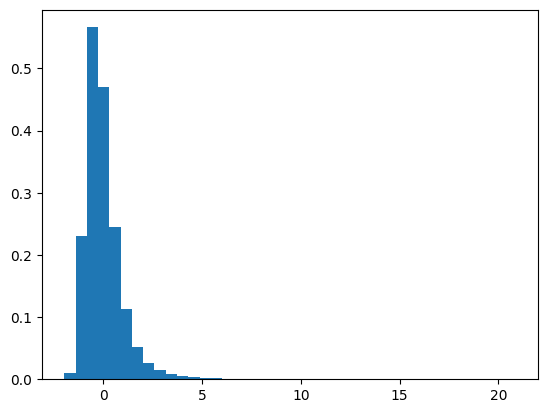

The resulting parameters:
  Lambda_1 = -0.397
  Lambda_2 = -0.787
  Lambda_3 = 0.163
  Lambda_4 = -0.009


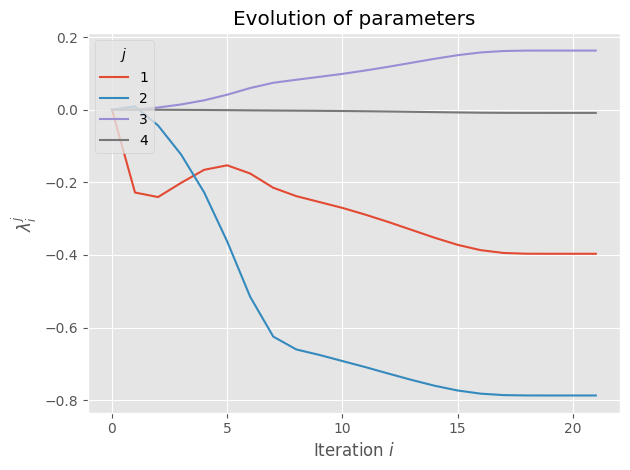

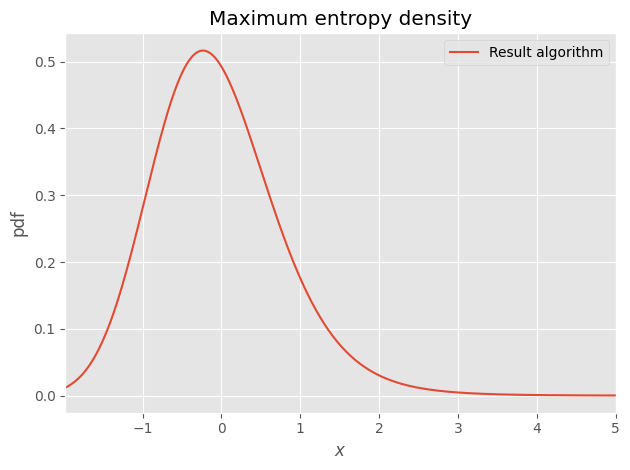

0.9951087227370701


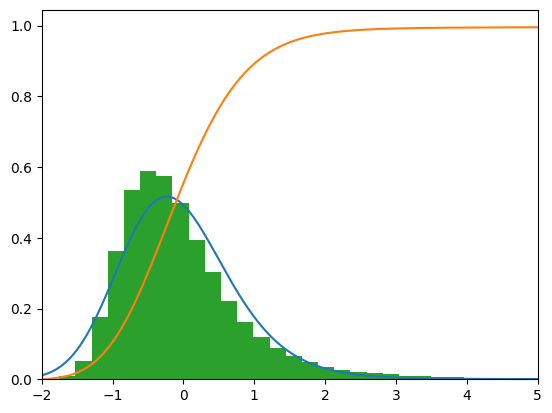

In [4]:

for i in range(1):
    arr = projections[i].flatten()
    print(f"Max: {np.max(arr):.2f} || Min: {np.min(arr):.2f}")
    print(f"Avg: {np.mean(arr):.1e} || Var: {np.var(arr):.4f}")
    arr_std = (arr-np.mean(arr))/np.std(arr)
    skew = np.mean(arr_std**3)
    kurt = np.mean(arr_std**4)
    print(f"Skewness: {skew:.2f} || Kurtosis: {kurt:.2f}")

    plt.hist(arr_std, density=True, bins=40)
    plt.show()
    
    l = np.min(arr_std)
    u = np.max(arr_std)
    n = 150

    ob_skewkurt = MaxEnt(support=(l,u),
                        n_quadrature=n,
                        b_constraints=d.b_constraint_skewkurt(skew,kurt),
                        f_vector=d.f_constraint_skewkurt)
    ob_skewkurt.visualize_algorithm()
    ob_skewkurt.visualize_solution(xlim=(l,5))

    N=500
    xx = np.linspace(l,5,N)

    y = ob_skewkurt.pdf(xx)
    yy = ob_skewkurt.cdf(xx)
    print(yy[-1])
    plt.plot(xx,y)
    plt.plot(xx,yy)
    plt.hist(arr_std, density=True, bins=100)
    plt.xlim(-2,5)
    plt.show()

In [14]:
# Z = rfft2(im)

# f, (ax1, ax2) = plt.subplots(1, 2)#, sharex='col', sharey='row'

# ax1.imshow(im)#, cmap=cm.Reds
# ax2.imshow(np.real(Z), cmap=cm.gray)
# plt.show()
# print(Z)

In [8]:
def batch_rejection_sample(density, xlim, C, N):
    Y = np.random.uniform(*xlim,size=N)
    U = np.random.uniform(size=N)
    mask = (U <= (xlim[1]-xlim[0])*density(Y)/C)
    return Y[mask]

def rejection_sampling(size, density, xlim, n_batch=5000):
    """Univariate rvs, on closed support [a,b]
    - density should be vectorizable"""

    # Determine C s.t. density(x) <= C * (b-a)^-1
    N = 10000
    xx = np.linspace(*xlim,N)
    yy = density(xx)
    C = np.max(yy)*(xlim[1]-xlim[0])
    
    results = np.array([])
    while(results.size<size):
        results = np.append(results, batch_rejection_sample(density,xlim,
                                                            C,N=1000))
    
    return results[:size]



In [ ]:
def standardize_image(image):
    mean = np.mean(image)
    var = np.var(image)
    return (image-mean)/np.sqrt(var)

def generate_copy_image(image_raw, 
                        i,
                        extra_upper_l=0.01, 
                        n=150, 
                        u_show=None):
    
    image = standardize_image(image_raw)
    image_flat = image.flatten()

    l = np.min(image)
    u = np.max(image) + extra_upper_l

    if(u_show == None):
        u_show = u

    skew = np.mean(image_flat**3)
    kurt = np.mean(image_flat**4)

    ob_skewkurt = MaxEnt(support=(l,u),
                        n_quadrature=n,
                        b_constraints=d.b_constraint_skewkurt(skew,kurt),
                        f_vector=d.f_constraint_skewkurt,
                        k_max=200, 
                        message_norm=False)
    # ob_skewkurt.visualize_algorithm()
    # ob_skewkurt.visualize_solution(xlim=(l,5))


    #sample from ME distribution
    n_sample = image_flat.size
    sample_ME = rejection_sampling(size=n_sample, 
                                   density=ob_skewkurt.pdf, 
                                   xlim=(l,u),
                                   n_batch=1000)
    
    res_sample = kstest(image_flat, sample_ME)
    n_breaks = 50
    bins = np.linspace(l, u_show, n_breaks)

    fig, ax = plt.subplots(3,1)
    ax[0].imshow(image_raw)

    ax[0].set_title(f"Raw image {i}")
    ax[0].grid()
    
    
    ax[1].hist(image_flat, density=True, bins=bins, alpha=0.6, label="Real")
    ax[1].hist(sample_ME,  density=True, bins=bins, alpha=0.6, label="Sampled")

    
    ax[1].set_title(f"Histogram of pixel values ($p$-val. KS: {res_sample.pvalue:.1e})")
    ax[1].set_xlabel("Pixel value")
    ax[1].set_ylabel("Density")
    ax[1].set_xlim(l, u_show)
    ax[1].set_yscale("log")
    ax[1].legend()

    plt.tight_layout()
    plt.savefig(f"skewness_kurtosis/generated_copy_example_{i}.pdf")
    plt.show()

    # res = kstest(image_flat, ob_skewkurt.cdf)
    # print(f"p-value of KS-test on cdf and real sample: {res.pvalue:.3e}")
    # print(f"p-value of KS-test on simulated and real sample: {res_sample.pvalue:.3e}")

In [9]:
projections_data = h5py.File(path_to_projections+f'projected_maps_slice_5_L1000N1800_{type[0]}_{sim[0]}_8192_lc0_alpha_3.6.h5','r')
projections = projections_data['proj_maps']

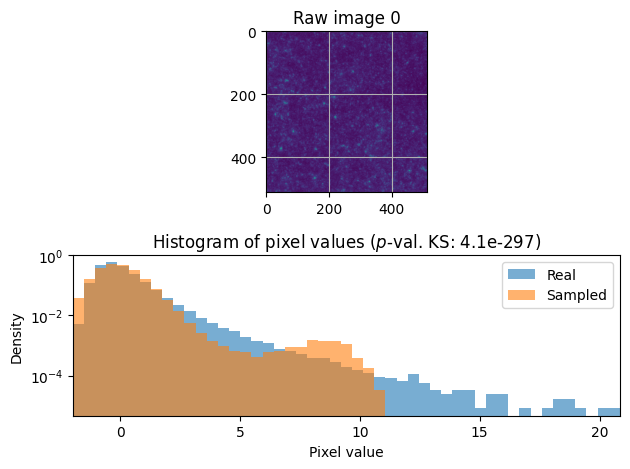

In [16]:
for i in range(1):
    generate_copy_image(projections[i],
                        i,
                        extra_upper_l=0, 
                        n=150)